In [67]:
import s3fs
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import duckdb

from datetime import datetime

In [2]:
fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "https://minio.minio-tenant",
        "aws_access_key_id": "admin",
        "aws_secret_access_key": "6bd71ace-8866-407a-9bcc-714bc5753f18",
        "verify": "/home/rafael/K8s/minio/minio-certs/cert-authority.pem",
    }
)

In [3]:
conn = duckdb.connect()

In [4]:
ghcn = pq.read_table("dutrajardim-fi/tables/ghcn.parquet", filesystem=fs)
firms = pq.read_table("dutrajardim-fi/tables/firms.parquet", filesystem=fs)

shapes_relations = pq.read_table("dutrajardim-fi/tables/shapes/osm/relations.parquet/adm=8", filesystem=fs)

In [63]:
def x_fmt_func(labels):
    return ticker.FuncFormatter(lambda x, y: datetime.strptime(labels[x][:2], "%m").strftime("%b") + labels[x][2:])

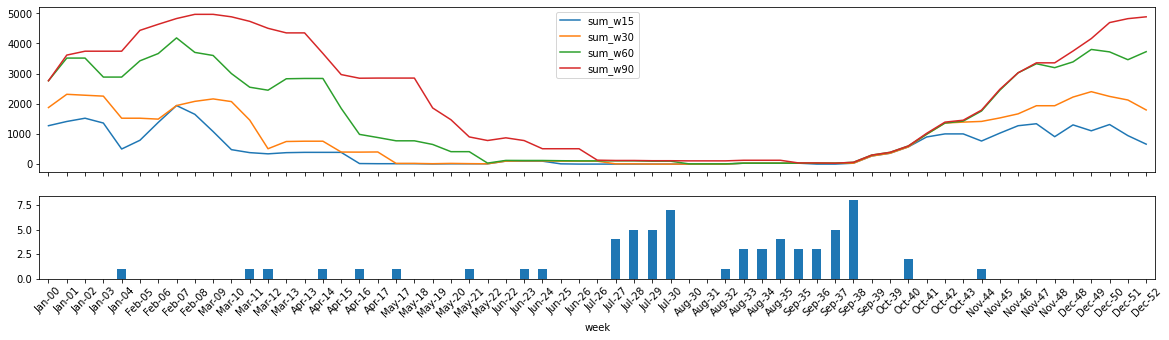

In [69]:
city = 'Belo Horizonte'
year = 2021

prcp_mv_sumation = conn.execute(f"""
SELECT week, MAX(sum_w15) as sum_w15, MAX(sum_w30) as sum_w30, MAX(sum_w60) as sum_w60, MAX(sum_w90) as sum_w90
FROM
    (SELECT
        days.date,
        STRFTIME(days.date, '%m-%W') AS week,
        SUM(ghcn.value) OVER (ORDER BY days.date RANGE INTERVAL 15 DAYS PRECEDING) AS sum_w15,
        SUM(ghcn.value) OVER (ORDER BY days.date RANGE INTERVAL 30 DAYS PRECEDING) AS sum_w30,
        SUM(ghcn.value) OVER (ORDER BY days.date RANGE INTERVAL 60 DAYS PRECEDING) AS sum_w60,
        SUM(ghcn.value) OVER (ORDER BY days.date RANGE INTERVAL 90 DAYS PRECEDING) AS sum_w90

    FROM 

        (SELECT CAST(generate_series AS DATE) AS date
        FROM GENERATE_SERIES(TIMESTAMP '{year - 1}-11-01', TIMESTAMP '{year}-12-31', INTERVAL 1 DAYS))
        
        days

    LEFT JOIN
        
        (SELECT value, CAST(STRFTIME(datetime, '%Y-%m-%d') AS DATE) AS date
        FROM ghcn
        JOIN shapes_relations ON ghcn.adm8 = shapes_relations.id
        WHERE
            distance_from_station = 0 AND
            shapes_relations.name = '{city}' AND
            element = 'PRCP')

        ghcn 

    ON ghcn.date = days.date)
WHERE date >= '{year}-01-01'
GROUP BY week
""").df()

weekly_fire_spots_counting = conn.execute(f"""
SELECT COUNT(*) AS fire_spots, STRFTIME(datetime, '%m-%W') as week
FROM firms
JOIN shapes_relations ON (firms.adm8 = shapes_relations.id)
WHERE 
    shapes_relations.name = '{city}' AND 
    YEAR(datetime) = {year}
GROUP BY week
ORDER BY week ASC
""").df()

weekly_data = conn.execute("""
SELECT 
    prcp_mv_sumation.*,
    CASE WHEN fire_spots IS NOT NULL THEN fire_spots ELSE 0 END fire_spots
FROM prcp_mv_sumation
LEFT JOIN weekly_fire_spots_counting ON prcp_mv_sumation.week = weekly_fire_spots_counting.week
ORDER BY prcp_mv_sumation.week
""").df()

fig, ax = plt.subplots(
    ncols=1, 
    nrows=2, 
    sharex=True, 
    figsize=(20, 5), 
    gridspec_kw={'height_ratios': [2, 1]}
)

weekly_data.plot(x='week', y=["sum_w15", "sum_w30",	"sum_w60", "sum_w90"], ax=ax[0])
weekly_data.plot(x='week', y='fire_spots', kind='bar', ax=ax[1], legend=False, rot=45)

ax[1].xaxis.set_major_formatter(x_fmt_func(weekly_data['week']))

plt.show()


In [57]:
conn.execute("""
SELECT 
    CORR(sum_w15, fire_spots) as w15_correlation,
    CORR(sum_w30, fire_spots) as w30_correlation,
    CORR(sum_w60, fire_spots) as w60_correlation,
    CORR(sum_w90, fire_spots) as w90_correlation
FROM weekly_data
""").df()

,w15_correlation,w30_correlation,w60_correlation,w90_correlation
0,-0.442614,-0.463456,-0.482646,-0.519861
